In [2]:
import operator
from typing import Annotated

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]
    n_api_call: Annotated[int, operator.add]

In [3]:
add_messages(["aaa"], ["bbb"])

[HumanMessage(content='aaa', id='9c478bf3-c926-47f1-adff-8a7a80a64c63'),
 HumanMessage(content='bbb', id='9e346164-4d5f-4f98-8f9f-c10bbd8199c5')]

In [4]:
from langchain_core.messages import SystemMessage

add_messages([SystemMessage("foo")], ["bar"])

[SystemMessage(content='foo', id='cd474807-699b-4d40-88fd-4ed172410129'),
 HumanMessage(content='bar', id='32cc85cb-9160-4179-ad99-878ca3b3591d')]

In [5]:
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults(max_results=1)

In [6]:
print("search_tool name:", search_tool.name)
print("search_tool description:", (search_tool.description))

search_tool name: tavily_search_results_json
search_tool description: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.


In [7]:
search_tool("how many people are in the world")

/Users/ken/.pyenv/versions/3.11.5/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


[{'url': 'https://www.worldometers.info/',
  'content': 'Current World Population. reached 8 billion in 2022, according to United Nations estimates. is projected to reach 9 billion in 2037, and 10 billion in 2060. has doubled in 40 years from 1959 (3 billion) to 1999 (6 billion). is currently (2024) growing at a rate of around 0.87% per year, adding around 71 million people per year to the total.'}]

In [8]:
from langgraph.prebuilt import ToolNode

tools = [search_tool]
tool_node = ToolNode(tools)  # LangGraphのノードとしてtoolを定義

In [9]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0, streaming=True)

In [10]:
bound_model = model.bind_tools(tools)  # 使用可能なtoolの情報をmodelに渡す

In [11]:
from typing import Literal


def should_continue(state: State) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # function callがない場合、終了
    if not last_message.tool_calls:
        return "__end__"
    # function callがある場合、次のnodeを実行
    return "action"


# modelを呼び出す関数
def call_model(state: State):
    response = model.invoke(state["messages"])
    # add_messages関数を使って、responseをstateに追加
    return {"messages": response, "n_api_call": 1}

In [12]:
from langgraph.graph import START, StateGraph

# 新規グラフを作成
workflow = StateGraph(State)

# ノードを追加
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 最初はagentから始まる
workflow.add_edge(START, "agent")

# 条件付きエッジを追加
workflow.add_conditional_edges(
    # agentノードに対して条件付きエッジを追加
    "agent",
    # 次に呼び出すノードを決定する関数
    should_continue,
)

# agentノードからactionノードへのエッジを追加
workflow.add_edge("action", "agent")

In [13]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [14]:
app = workflow.compile(checkpointer=checkpointer)

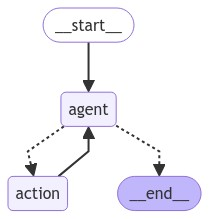

In [15]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "test thread"}}
input_message = HumanMessage(content="how many people are in the world", user_id="1")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

how many people are in the world
================================== Ai Message ==================================

As of 2021, the estimated global population is around 7.9 billion people.


In [17]:
app.invoke({"messages": [input_message]}, config, debug=True)

[2:checkpoint] State at the end of step 2:
{'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb'),
              AIMessage(content='As of 2021, the estimated global population is around 7.9 billion people.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ef1cb02f-52a4-4509-8f33-4ee48212a6c6-0')],
 'n_api_call': 1}
[3:tasks] Starting step 3 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb', user_id='1')]}
[3:writes] Finished step 3 with writes to 1 channel:
- messages -> [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb', user_id='1')]
[3:checkpoint] State at the end of step 3:
{'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb', user_id='1'),
              AIMessage(content='As of 2021, th

{'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb', user_id='1'),
  AIMessage(content='As of 2021, the estimated global population is around 7.9 billion people.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ef1cb02f-52a4-4509-8f33-4ee48212a6c6-0'),
  AIMessage(content='Please note that this number is constantly changing due to births, deaths, and other factors.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-9a435d84-6b3a-45a1-b370-1ad1c898e6dd-0')],
 'n_api_call': 2}

In [18]:
checkpointer.get(config)

{'v': 1,
 'ts': '2024-08-24T08:06:14.614320+00:00',
 'id': '1ef61efb-bb65-6c76-8004-1d789a26b75f',
 'channel_values': {'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb'),
   AIMessage(content='As of 2021, the estimated global population is around 7.9 billion people.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ef1cb02f-52a4-4509-8f33-4ee48212a6c6-0'),
   AIMessage(content='Please note that this number is constantly changing due to births, deaths, and other factors.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-9a435d84-6b3a-45a1-b370-1ad1c898e6dd-0')],
  'n_api_call': 2,
  'agent': 'agent'},
 'channel_versions': {'__start__': 5,
  'messages': 6,
  'start:agent': 6,
  'agent': 6,
  'n_api_call': 6},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': 4},
  'agent': {'start:agent': 5}},
 'pending_sends': []}

In [19]:
list(checkpointer.list(config))

[CheckpointTuple(config={'configurable': {'thread_id': 'test thread', 'checkpoint_ns': '', 'checkpoint_id': '1ef61efb-bb65-6c76-8004-1d789a26b75f'}}, checkpoint={'v': 1, 'ts': '2024-08-24T08:06:14.614320+00:00', 'id': '1ef61efb-bb65-6c76-8004-1d789a26b75f', 'channel_values': {'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb'), AIMessage(content='As of 2021, the estimated global population is around 7.9 billion people.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ef1cb02f-52a4-4509-8f33-4ee48212a6c6-0'), AIMessage(content='Please note that this number is constantly changing due to births, deaths, and other factors.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-9a435d84-6b3a-45a1-b370-1ad1c898e6dd-0')], 'n_api_call': 2, 'agent': 'agent'}, 'channel_versions': {'__start__': 5, 'messages': 6, 'start:agent': 6, 'agent': 6, 'n_api_call': 6}, 

In [20]:
input_message = HumanMessage(content="in 2000")
for event in app.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in 2000
================================== Ai Message ==================================

, the world was preparing for the new millennium with excitement and uncertainty. Technology was rapidly advancing, with the rise of the internet and the dot-com bubble reaching its peak. The Y2K bug was a major concern, as people feared that computer systems would crash when the year changed from 1999 to 2000. However, the new year arrived without any major issues.

In politics, George W. Bush was elected as the 43rd President of the United States after a controversial election that was ultimately decided by the Supreme Court. The September 11th terrorist attacks in 2001 would have a profound impact on the world and shape the rest of the decade.

In popular culture, the year 2000 saw the release of iconic movies such as "Gladiator," "X-Men," and "Cast Away." The music scene was dominated by artists like Britney Spea

In [21]:
checkpointer.get(config)

{'v': 1,
 'ts': '2024-08-24T08:06:14.614320+00:00',
 'id': '1ef61efb-bb65-6c76-8004-1d789a26b75f',
 'channel_values': {'messages': [HumanMessage(content='how many people are in the world', id='286d00f9-4a58-4686-bbd8-774f335875fb'),
   AIMessage(content='As of 2021, the estimated global population is around 7.9 billion people.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ef1cb02f-52a4-4509-8f33-4ee48212a6c6-0'),
   AIMessage(content='Please note that this number is constantly changing due to births, deaths, and other factors.', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-9a435d84-6b3a-45a1-b370-1ad1c898e6dd-0')],
  'n_api_call': 2,
  'agent': 'agent'},
 'channel_versions': {'__start__': 5,
  'messages': 6,
  'start:agent': 6,
  'agent': 6,
  'n_api_call': 6},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': 4},
  'agent': {'start:agent': 5}},
 'pending_sends': []}

In [22]:
# langgraph_checkpoint_postgresが必要
from langgraph.checkpoint.postgres import PostgresSaver

with PostgresSaver.from_conn_string(
    "postgresql://postgres@localhost:5432/ml-workshop"
) as pg_checkpointer:
    pg_checkpointer.setup()  # テーブルを作成
    app_with_pg = workflow.compile(checkpointer=pg_checkpointer)
    app_with_pg.invoke({"messages": ["How many people in Japan"]}, config)

以下のようなテーブルが作成される

```
% psql -U postgres -d ml-workshop -c "\d"                                  
                 List of relations
 Schema |         Name          | Type  |  Owner   
--------+-----------------------+-------+----------
 public | checkpoint_blobs      | table | postgres
 public | checkpoint_migrations | table | postgres
 public | checkpoint_writes     | table | postgres
 public | checkpoints           | table | postgres
(4 rows)
```

In [43]:
# langgraph_checkpoint_sqliteが必要
from langgraph.checkpoint.sqlite import SqliteSaver

with SqliteSaver.from_conn_string("ml-workshop.db") as sqlite_checkpointer:
    app_with_sqlite = workflow.compile(checkpointer=sqlite_checkpointer)
    app_with_sqlite.invoke({"messages": ["How many people in Japan"]}, config)